# Анализ поведения пользователей мобильного приложения. <br> Анализ A/A/B-теста.

## Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.<br>
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.<br>
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

<b>Описание данных:</b><br>
Каждая запись в логе — это действие пользователя, или событие.
*	EventName — название события;
*	DeviceIDHash — уникальный идентификатор пользователя;
*	EventTimestamp — время события;
*	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Загрузка данных и подготовка их к анализу

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
import math as mth
from scipy import stats as st

# Загрузка данных
data = pd.read_csv('datasets/logs_exp.csv', sep='\t')

#Смотрим общую информацию
display(data.head())
print('Общая информация:')
data.info()
print()
print('Количество пропуков:')
print(round((data.isna().mean()*100),2))
print()
print('Количество полных дубликатов:', data.duplicated().sum())
print()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Количество пропуков:
EventName         0.0
DeviceIDHash      0.0
EventTimestamp    0.0
ExpId             0.0
dtype: float64

Количество полных дубликатов: 413



Необходимо поменять названия в колонках, изменить формат времени и убрать дубликаты.

In [2]:
# Убираем полные дубликаты
data = data.drop_duplicates()

# Меняем названия в колонках
data = data.rename(
    columns={'EventName':'eventname',
             'DeviceIDHash':'device_id',
             'EventTimestamp':'event_dt',
             'ExpId':'exp_id'
            }
)
# Поменяем формат времени на datetime
data['event_dt'] = pd.to_datetime(data['event_dt'] , unit='s')
data['dt'] = data['event_dt'].dt.date
data.head()

,eventname,device_id,event_dt,exp_id,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [3]:
# Посмотрим на распределение групп теста
group = data['exp_id'].value_counts().sort_index(ascending=True).to_frame()
group['pct'] = round(group['exp_id']/group['exp_id'].sum()*100)
group

,exp_id,pct
246,80181,33.0
247,77950,32.0
248,85582,35.0


In [4]:
# Посмотрим на пересечение групп
duplicatedusers = data.groupby('device_id').agg({'exp_id':['nunique', 'unique']})
duplicatedusers.columns = ['groops_count', 'groop_number']
duplicatedusers = duplicatedusers[duplicatedusers['groops_count'] > 1]
display(duplicatedusers.head())
print('Количество пользователей попавших в обе группы:', len(duplicatedusers))

,groops_count,groop_number
device_id,,


Количество пользователей попавших в обе группы: 0


Пересечения пользователей в группах не обнаружено.

## Проверка данных

In [5]:
# Изучим сколько пользователей и событий в логе
print('Всего событий в логе:', len(data))
print('Всего уникальных событий в логе:', len(data['eventname'].unique()))
print('Всего пользователей в логе:', len(data['device_id'].unique()))
print('Cобытий приходящихся на пользователя:', round(len(data)/len(data['device_id'].unique())))

Всего событий в логе: 243713
Всего уникальных событий в логе: 5
Всего пользователей в логе: 7551
Cобытий приходящихся на пользователя: 32


In [6]:
# Временной период тестирования
print('Минимальная дата в логе:', data['event_dt'].min())
print('Максимальная дата в логе:', data['event_dt'].max())

Минимальная дата в логе: 2019-07-25 04:43:36
Максимальная дата в логе: 2019-08-07 21:15:17


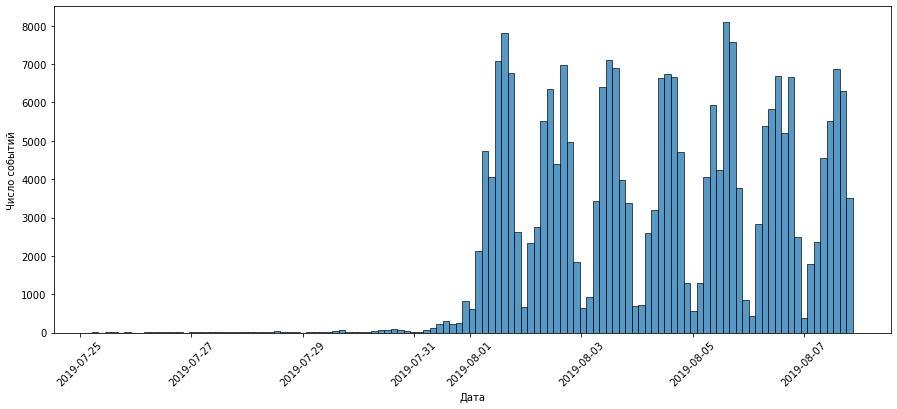

In [7]:
# Построим гистограмму по дате и времени
data['hours'] = data['event_dt'].dt.round('1h')
plt.figure(figsize=(15,6))
sns.histplot(data, x='hours')
plt.xlabel('Дата')
plt.ylabel('Число событий')
plt.xticks(rotation=45) 
plt.show()

Период с 25.07.2019 по 01.08.2019 не содержит полные и полезные данные. Ими можно пренебречь.<br>
Полными данными мы располагаем за период с 01.08.2019 по 07.08.2019.

In [8]:
# Оставим только нужные данные
data1 = data[data['event_dt'] >= '2019-08-01']
fall_events = len(data)-len(data1)
fall_users = len(data['device_id'].unique())-len(data1['device_id'].unique())
# Сколько потеряли событий и пользователей
print('Потерянных событий:', len(data)-len(data1))
print('Доля потерянных событий: {}%'.format(round(fall_events/len(data)*100, 2)))
print('Потерянных пользователей:', fall_users)
print('Доля потерянных пользователей: {}%'.format(round(fall_users/len(data['device_id'].unique())*100, 2)))
      
# Посмотрим распределение по группам
group1 = data1['exp_id'].value_counts().sort_index(ascending=True).to_frame()
group1['pct'] = round(group1['exp_id']/group1['exp_id'].sum()*100)
group1

Потерянных событий: 2826
Доля потерянных событий: 1.16%
Потерянных пользователей: 17
Доля потерянных пользователей: 0.23%


,exp_id,pct
246,79302,33.0
247,77022,32.0
248,84563,35.0


Отбросив старые данные мы потеряли 1.16% событий и 0.23% пользователей. Это незначительная доля которая не скажется на общем результате теста. Распределение в группах осталось прежним.

## Воронка событий

In [9]:
# Смотрим на уникальные события
events = data1['eventname'].value_counts().reset_index()
events.columns = ['eventname', 'count']
events

,eventname,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Всего у нас 5 уникальных событий.

In [10]:
# Смотрим пользователей на каждом этапе
users_event = data1.pivot_table(index=['eventname'], values='device_id', aggfunc={'nunique','count'}).reset_index()
users_event.columns = ['eventname', 'count', 'users_count']
users_event['pct'] = round(users_event['users_count']*100/len(data['device_id'].unique()),2)
users_event = users_event.sort_values(by='pct', ascending=False)
users_event

,eventname,count,users_count,pct
1,MainScreenAppear,117328,7419,98.25
2,OffersScreenAppear,46333,4593,60.83
0,CartScreenAppear,42303,3734,49.45
3,PaymentScreenSuccessful,33918,3539,46.87
4,Tutorial,1005,840,11.12


Последовательность цепочки событий складывается следующим образом: <br>
MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

Обучение не является частью основной воронки и его смотрят всего лишь 11.12% пользователей.<br>
Главный экран видели только 98.25% пользователей. Следовательно 1.75% пользователей попали сразу на экран предложения/услуги/товара минуя главный экран.<br>
На экран предложения попадают 60.83% пользователей. Это значит что около 40% пользователей пропадают уже после первого шага.

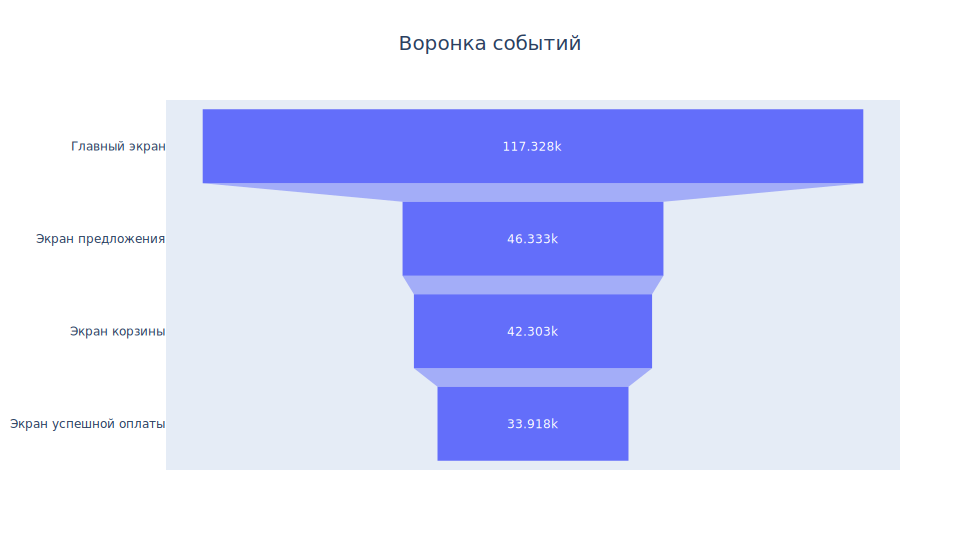

In [11]:
# Строим воронку событий
events = events[events['eventname'] != 'Tutorial'] # Исключили Tutorial
fig = go.Figure(
    go.Funnel(
        y=['Главный экран', 'Экран предложения', 'Экран корзины', 'Экран успешной оплаты'],
        x=events['count'],
    )
)
fig.update_layout(title={'text':"Воронка событий", 'font':dict(size=20), 'x':0.5})
fig.show(renderer='svg', width=980, height=550)

In [12]:
# Конверсия пользователей
funnel = data.groupby('eventname',as_index=False).agg({'device_id':'nunique'}).sort_values(by='device_id',ascending=False)
funnel = funnel[funnel['eventname'] != 'Tutorial']
funnel['conv'] = round(funnel['device_id']/7439*100, 2)
funnel['conv_step'] = round(100*funnel['device_id']/funnel['device_id'].shift(), 2)
funnel

,eventname,device_id,conv,conv_step
1,MainScreenAppear,7439,100.00,NaN
2,OffersScreenAppear,4613,62.01,62.01
0,CartScreenAppear,3749,50.40,81.27
3,PaymentScreenSuccessful,3547,47.68,94.61


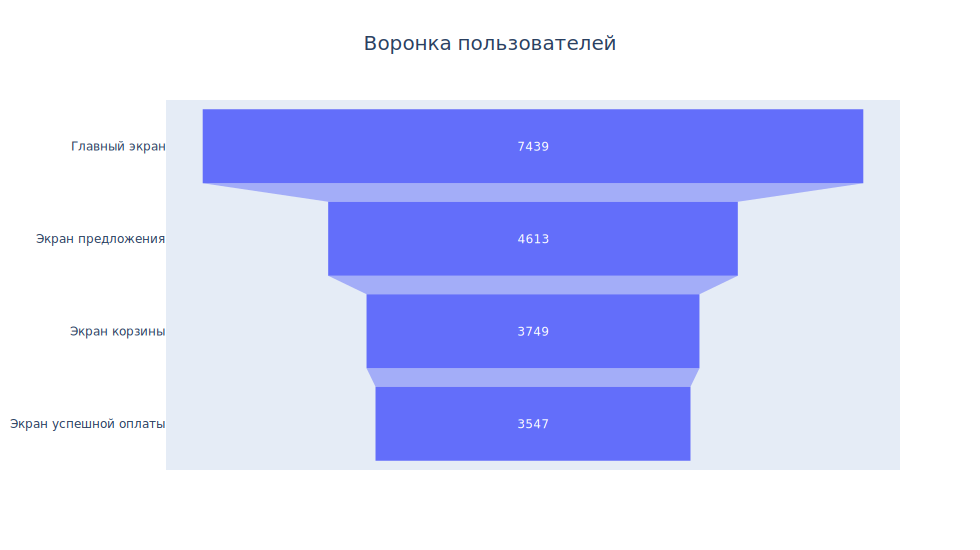

In [13]:
fig = go.Figure(
    go.Funnel(
        y=['Главный экран', 'Экран предложения', 'Экран корзины', 'Экран успешной оплаты'],
        x=funnel['device_id'],
    )
)
fig.update_layout(title={'text':"Воронка пользователей", 'font':dict(size=20), 'x':0.5})
fig.show(renderer='svg', width=980, height=550)

Все как и прежде - около 38% пользователей теряюся на первом шаге при переходе с главного экрана на экран предложения.<br>
Порядка 47,7% пользователей проходят от первого события до успешной оплаты.
Около 5,4% теряются на переходе с экрана корзины до успешной оплаты товара. Возможно есть техническая проблема в оплате, а возможно некоторые люди передумали покупать или используют корзину как избранные товары.

## Результаты эксперимента

In [14]:
# Количество пользователей по группам
users = data1.groupby('exp_id').agg({'device_id':'nunique'}).reset_index()
users

,exp_id,device_id
0,246,2484
1,247,2513
2,248,2537


Есть 2 контрольные группы для А/А-эксперимента<br>
Проверим, находят ли статистические критерии разницу между выборками 246 и 247 для проверки корректности всех механизмов и расчетов.<br>
<b>
H0 - Доли групп составляют 50%<br>
H1 - Доли групп отличаются от 50%

In [15]:
users.query('exp_id == 246')

,exp_id,device_id
0,246,2484


In [16]:
# Проверка гипотезы о равенстве долей используя Z-критерий
# Задаем критический уровень статистической значимости для последующих тестов
alpha = 0.05

_, pvalue = proportions_ztest(
    count = users.query('exp_id == 246')['device_id'][0],
    nobs = users.query('exp_id == [246,247]')['device_id'].sum(),
    value = 0.5
)
if pvalue < alpha:
    print("Отвергаем H0, доля отличается от 50%")
else:
    print("Не отвергаем H0, доли групп одинаковы!")

Не отвергаем H0, доли групп одинаковы!


In [17]:
pvalue

0.6816211476613262

In [18]:
# Создадим таблицу с результатами тестов по каждому событию и разбивкой по группам
tests = data1.pivot_table(index='eventname', columns='exp_id', values='device_id', aggfunc='nunique')
tests.columns =[246, 247, 248]
tests[493] = tests[246] + tests[247]
tests = tests[tests.index != 'Tutorial'].sort_values(by=493, ascending=False)
tests

,246,247,248,493
eventname,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


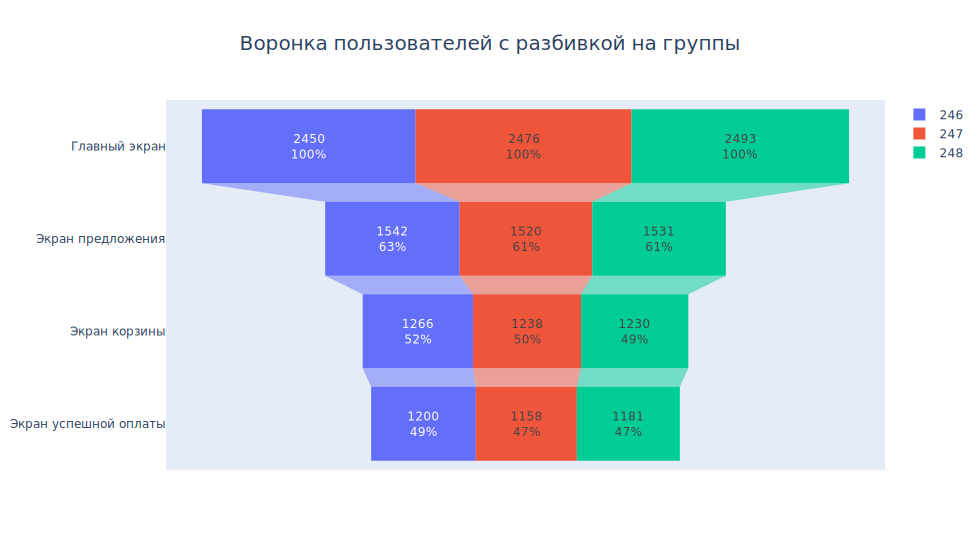

In [19]:
# Визуализация трех тестовых групп
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = '246',
    y = ['Главный экран', 'Экран предложения', 'Экран корзины', 'Экран успешной оплаты'],
    x = tests[246],
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = ['Главный экран', 'Экран предложения', 'Экран корзины', 'Экран успешной оплаты'],
    x = tests[247],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = ['Главный экран', 'Экран предложения', 'Экран корзины', 'Экран успешной оплаты'],
    x = tests[248],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(title={'text':"Воронка пользователей c разбивкой на группы", 'font':dict(size=20), 'x':0.5})
fig.show(renderer='svg', width=980, height=550)

In [20]:
# Добавим объедененную группу в таблицу групп
users.loc[3] = [493, 4997]
users = users.set_index(users.columns[0])
users

,device_id
exp_id,
246,2484
247,2513
248,2537
493,4997


Для проверки гипотез воспользуемся Z-критерием и применим поправку Бонферрони, так как проводим множественное сравнение.<br>
В нашем случае мы будем проводить 16 сравнений, следовательно, bonferroni_alpha будет равно alpha / 16.

Сформулируем гипотезы:<br>
<b>
    H0: Нет отличий между группами<br>
    H1: Отличие между группами статистически достоверно
</b>

In [21]:
# Напишем функцию для проверки гипотез
def check_hyp(gp1, gp2, eventname):
    successes1 = tests.loc[eventname, gp1]
    successes2 = tests.loc[eventname, gp2]
    trials1 = users.loc[gp1, 'device_id']
    trials2 = users.loc[gp2, 'device_id']
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    bonferroni_alpha = alpha / 16
    print(p_value)
    print('Проверка для групп {} и {}, cобытие: {}, p-value = {p_value}'.format(gp1, gp2, eventname, p_value=p_value))
    if p_value < bonferroni_alpha:
        print('Отвергаем H0: между группами есть статистически значимая разница')
    else:
        print('Не отвергаем H0: группы статистически не отличаются') 

In [22]:
# Сравнение результатов А/А теста
for eventname in tests.index:
    check_hyp(246, 247, eventname)
    print()

0.7570597232046099
Проверка для групп 246 и 247, cобытие: MainScreenAppear, p-value = 0.7570597232046099
Не отвергаем H0: группы статистически не отличаются

0.2480954578522181
Проверка для групп 246 и 247, cобытие: OffersScreenAppear, p-value = 0.2480954578522181
Не отвергаем H0: группы статистически не отличаются

0.22883372237997213
Проверка для групп 246 и 247, cобытие: CartScreenAppear, p-value = 0.22883372237997213
Не отвергаем H0: группы статистически не отличаются

0.11456679313141849
Проверка для групп 246 и 247, cобытие: PaymentScreenSuccessful, p-value = 0.11456679313141849
Не отвергаем H0: группы статистически не отличаются



Обе контрольные группы показывают идентичные результаты. Мы можем быть уверены в точности проведенного тестирования

In [23]:
# Сравнение результатов А/B теста
# A1 и # B
for eventname in tests.index:
    check_hyp(246, 248, eventname)
    print()

0.2949721933554552
Проверка для групп 246 и 248, cобытие: MainScreenAppear, p-value = 0.2949721933554552
Не отвергаем H0: группы статистически не отличаются

0.20836205402738917
Проверка для групп 246 и 248, cобытие: OffersScreenAppear, p-value = 0.20836205402738917
Не отвергаем H0: группы статистически не отличаются

0.07842923237520116
Проверка для групп 246 и 248, cобытие: CartScreenAppear, p-value = 0.07842923237520116
Не отвергаем H0: группы статистически не отличаются

0.2122553275697796
Проверка для групп 246 и 248, cобытие: PaymentScreenSuccessful, p-value = 0.2122553275697796
Не отвергаем H0: группы статистически не отличаются



In [24]:
# A2 и B
for eventname in tests.index:
    check_hyp(247, 248, eventname)
    print()

0.4587053616621515
Проверка для групп 247 и 248, cобытие: MainScreenAppear, p-value = 0.4587053616621515
Не отвергаем H0: группы статистически не отличаются

0.9197817830592261
Проверка для групп 247 и 248, cобытие: OffersScreenAppear, p-value = 0.9197817830592261
Не отвергаем H0: группы статистически не отличаются

0.5786197879539783
Проверка для групп 247 и 248, cобытие: CartScreenAppear, p-value = 0.5786197879539783
Не отвергаем H0: группы статистически не отличаются

0.7373415053803964
Проверка для групп 247 и 248, cобытие: PaymentScreenSuccessful, p-value = 0.7373415053803964
Не отвергаем H0: группы статистически не отличаются



In [25]:
# A1+A2 и B
for eventname in tests.index:
    check_hyp(493, 248, eventname)
    print()

0.29424526837179577
Проверка для групп 493 и 248, cобытие: MainScreenAppear, p-value = 0.29424526837179577
Не отвергаем H0: группы статистически не отличаются

0.43425549655188256
Проверка для групп 493 и 248, cобытие: OffersScreenAppear, p-value = 0.43425549655188256
Не отвергаем H0: группы статистически не отличаются

0.18175875284404386
Проверка для групп 493 и 248, cобытие: CartScreenAppear, p-value = 0.18175875284404386
Не отвергаем H0: группы статистически не отличаются

0.6004294282308704
Проверка для групп 493 и 248, cобытие: PaymentScreenSuccessful, p-value = 0.6004294282308704
Не отвергаем H0: группы статистически не отличаются



Похоже, что изменение шрифтов в приложении никак не повлияло на пользователей. Значит опасения менеджеров о том, что пользователям будет непривычно с новыми шрифтами будут развеяны. Тест можно считать успешным.

## Выводы

В работе стояла цель разобраться как ведут себя пользователи приложения и изучить результаты А/А/В-теста, в котором 2 контрольние группы видели версию приложения со старыми шрифтами, а эксперементальная с новыми.
В нашем распоряжении был лог с данными за период с 25.07.2019 по 07.08.2019, но часть данных была неполной. После отчистки мы получили данные за период 01.08.2019 по 07.08.2019 т.е неделя.


* Обучение смотрят всего лишь 11.12% пользователей. Можно предположить, что пользователи недеются на понятный и простой интерфейс и пропускают этот шаг.
* От первого события (главный экран) до последнего (успешная оплата) доходит 47.7% пользователей.
* Больше всего пользователей теряется на шаге перехода с главного экрана к экрану предложения - 38%.
* С предпоследнего шага (экран корзины) до последнего (успешная оплата) теряется 5.4% пользователей. Возможно, есть какие-то технические трудности при оплате.
* Группы для А/А/В-тестирования были хорошо сформированы, статистической разницы не обнаружено.
* По результатам А/А/В-теста не было выявлено различий между контрольными и эксперементальной группами, что говорит о том, что замена шрифтов никак не повлияла на пользователей.